<a href="https://colab.research.google.com/github/hughjonesd/course-nlp/blob/master/explore_ota_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring SVD with the OTA data

The "OTA data" is "A Corpus of English Dialogues 1560-1760".

I've added it to my github fork of fastai/course-nlp.

My plan:

* Get the files into a format I can work with
* Do some simple SVD

I started by working on my home computer. PyCharm is available for free (even the professional version, for academics). Then I copied the
code into a new notebook.

# Looking at the data

I opened one of my text files. They record English dialogues - some
real records of e.g. trials, some from plays or language learning textbooks.

The files start with some metadata. Then the dialogues. The text
uses the following codes:

    (^..........^) - font other than the basic font
    (\..........\) - foreign language
    [}..........}] - heading
    [{..........{] - editorial emendation (i.e. a correction)
    [\..........\] - editorial comment 
    [^..........^] - corpus compilers’ comment
    [$..........$] - running text other than direct speech
    [^...^]        - text on the line omitted
    [^---^]        - text in the same sentence omitted

I'll probably want to omit most of those, but we'll worry about that later.

Text itself has lots of proper names, and lots of apostrophes, e.g.
"subdu'd" for "subdued". Maybe lemmatization would help?

# How I worked out the code

Google Is Your Friend. I constantly googled for e.g. 
"countvectorizer", "python file path", "numpy sparse array". Links
usually took me to documentation or to help sites. Beware of spammy
"tutorial websites".



In [1]:
# Imports

import os
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [ ]:
# this clones my whole repository, including a copy of the OTA data
# normally should be careful about exposing other people's data publicly
# but I'm in a hurry...

!git clone https://github.com/hughjonesd/course-nlp

In [7]:
# getting a list of file paths

data_folder = Path("course-nlp/ota_20.500.12024_2507/CEDPlain")

ced_filenames = os.listdir(data_folder)
ced_filenames = [data_folder/fn for fn in ced_filenames]

ced_filenames[0:4]

[PosixPath('course-nlp/ota_20.500.12024_2507/CEDPlain/D1WNOTOR'),
 PosixPath('course-nlp/ota_20.500.12024_2507/CEDPlain/D5CGARRI'),
 PosixPath('course-nlp/ota_20.500.12024_2507/CEDPlain/D5CHOADL'),
 PosixPath('course-nlp/ota_20.500.12024_2507/CEDPlain/D2WPENDL')]

# Creating the term-document matrix

From the scikit-learn documentation for CountVectorizer (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

"input": If ‘filename’, the sequence passed as an argument to fit is expected to be a list
of filenames that need reading to fetch the raw content to analyze.


In [9]:

# I discovered the encoding was iso-8859-1 after a crash when I used the default utf8
vectorizer = CountVectorizer(
                input      = 'filename',
                stop_words = 'english',
                encoding   = 'iso-8859-1',
             )

# we use todense() here so that linalg below can get to work
# for speed, could use scipy.sparse.linalg, but it doesn't take long anyway

count_array = vectorizer.fit_transform(raw_documents = ced_filenames).todense()

# let's look at the vocab
vocab = vectorizer.get_feature_names()

# hmm, that's not good... 
print(vocab[:10])
# ok but that's better:
print(vocab[1000:1010])
# those words aren't lemmatized, it might help to do that first
# but not sure how to lemmatize a file
# possibly the "preprocessor" argument to CountVectorizer might help



['000', '10', '100', '1000', '10000', '100c1', '100c2', '101', '101c1', '101c2']
['accomplishments', 'accomplisht', 'accompt', 'accomptant', 'accompte', 'accompted', 'accompteth', 'accompts', 'accord', 'accordance']


# Running a simple SVD

This is just cut-n-paste from the tutorial.

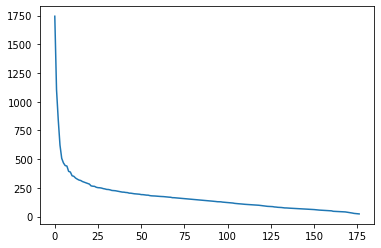

In [10]:
U, s, Vh = linalg.svd(count_array, full_matrices=False)


OK, what have we got?


In [12]:
# this is also copy-pasted
num_top_words=15
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

show_topics(Vh[0:10])

# Some topics are clearly about trials (deponent, examinate). 
# Others look more related to 
# plays (madam, mrs, love...)

['dampned remisson graines vnderstanded kirkham distributyng forasmuche sheadyng represente digestiou amendement rememberance dwellyng communicatyng sainct',
 'said sir haue good shall thou come man let make hee men shee thee doe',
 'said examinate deponent did saith came house hym elizabeth john shee sample went ad sais',
 'sir said madam ll love mrs lady tis says self think little dear wou deponent',
 'did rupert yes admiral mrs ships royal oak saw queen ship enemy time line shot',
 'lord queen duke deponent mrs majesty says gen matter men child letter bed man scotish',
 'lord gen att mohun hill did saith howard mountford mrs col examinate sidney steward shee',
 'madam mrs says love mr men dear ll wou know man think come amoranda wife',
 'shee duke saith examinate queen hee wife mother time letter saide scotish quoth told examinat',
 'duke men court said law shall answer letter matter scotish king read serj god letters']

A plot of the importance of the topics, from the diagonal s matrix.

This seems to show an "elbow", a bit like factor analysis.

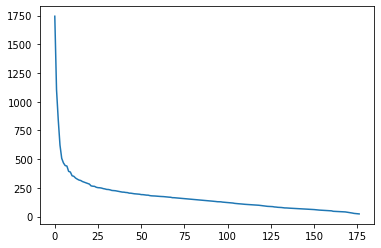

In [13]:

plt.plot(s)

# Open questions

* What if I want fewer topics than there are documents?
* Should I use stopwords?
* How can I tell whether these topics are useful?